In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import os

In [2]:
DATA_PATH = os.path.join('../Data')
L_NORM = os.path.join(DATA_PATH, 'L_norm.csv')
A_NORM = os.path.join(DATA_PATH, 'A_norm.csv')
L_BIN = os.path.join(DATA_PATH, 'L_binarized.csv')
A_BIN = os.path.join(DATA_PATH, 'A_binarized.csv')
METADATA = os.path.join(DATA_PATH, 'metadata.csv')
DF_GENES = os.path.join(DATA_PATH, 'df_genes_complete.csv')

In [3]:
df_genes = pd.read_csv(DF_GENES, index_col=0)

In [4]:
metadata = pd.read_csv(METADATA, dtype='object').set_index('genome_id')

In [5]:
L_norm = pd.read_csv(L_NORM, index_col=0)
A_norm = pd.read_csv(A_NORM, index_col=0)

In [6]:
# read in P matrix for new strains
P_new = pd.read_csv('../Work/combined_P_matrix.csv', index_col=0)
P_new_acc = P_new.loc[L_norm.index]

# Infer affinities of new strains

In [7]:
import infer_affinities

In [8]:
A_new = infer_affinities.infer_affinities(L_norm.to_numpy(),  P_new_acc.to_numpy(), n_jobs=4)
A_new = pd.DataFrame(A_new, index = L_norm.columns, columns = P_new_acc.columns)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
def recommended_threshold(A_norm, i):
    column_data_reshaped = A_norm.loc[i].values.reshape(-1, 1)
    
    # 3-means clustering
    kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
    kmeans.fit(column_data_reshaped)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    # Find the cluster with the highest mean
    highest_mean_cluster = np.argmax(centers)
    
    # Binarize the row based on the cluster with the highest mean
    binarized_row = (labels == highest_mean_cluster).astype(int)
    
    # Find k-means-recommended threshold using min value that still binarizes to 1
    x = pd.Series(dict(zip(A_norm.columns, binarized_row)))
    threshold = A_norm.loc[i, x[x==1].index].min()
    
    return threshold

In [19]:
P_new_acc['BVBRC_550.5265'].sum()

42

<Axes: >

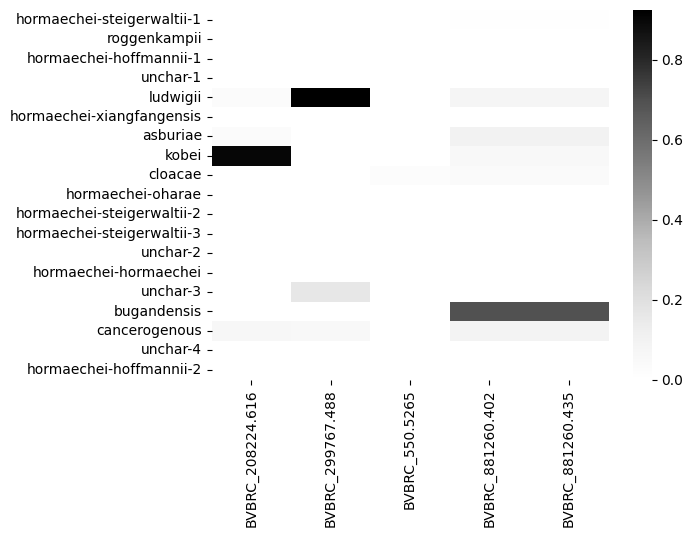

In [10]:
# Basic binarization with thresholds from original matrix:
A_binarized_new = pd.DataFrame(np.zeros_like(A_new.values), index=A_norm.index, columns=A_new.columns)


for idx in A_norm.index: # 90% of threshold for original A matrix used to account for CD-HIT clustering incongruities on strains
    cond = A_new.loc[idx] >= recommended_threshold(A_norm, idx) * .9
    A_binarized_new.loc[idx,cond] = 1

sns.heatmap(A_new, cmap='Greys')

# Classify to nearest Mash Cluster

In [44]:
MASH_DISTANCES = os.path.join('..','Work','combined_mash_distances.csv')
MASH_CLUSTER_LABELS = os.path.join(DATA_PATH, 'mash_cluster_type_matches.tsv')

In [54]:
mash_distances = pd.read_csv(MASH_DISTANCES, dtype = 'object').set_index('genome_id').astype(float)
mash_cluster_labels = pd.read_csv(MASH_CLUSTER_LABELS, dtype = 'object', index_col=0, sep='\t', header=None)

In [56]:
strain_mash_clusters = pd.DataFrame(columns = ['best_cluster', 'cluster_label', 'nearest_mash_distance_mean'])

In [57]:
for new_strain in mash_distances.columns:
    top_distances = mash_distances[new_strain].sort_values().index[:5] # get 5 closest strains
    mash_cluster = int(float(metadata.loc[top_distances].complete_mash_cluster.value_counts().idxmax()))
    mash_cluster_label = mash_cluster_labels.loc[mash_cluster,1]
    strain_mash_clusters.loc[new_strain] = [mash_cluster,
                                            mash_cluster_label,
                                            mash_distances[new_strain].sort_values().head(5).mean()]

In [58]:
strain_mash_clusters

,best_cluster,cluster_label,nearest_mash_distance_mean
BVBRC_208224.616_distances,10,kobei,0.010417
BVBRC_299767.488_distances,19,ludwigii,0.011514
BVBRC_550.5265_distances,21,cloacae cloacae,0.129931
BVBRC_881260.402_distances,18,bugandensis,0.016247
BVBRC_881260.435_distances,18,bugandensis,0.016392
